In [56]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import math

In [6]:
# http://benalexkeen.com/feature-scaling-with-scikit-learn/
# https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py

def load_dataset(is_normalize=True):
    global dataset, labels
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader) # skip the first row
        temp = []
        for idx, row in enumerate(reader):
            temp.append(row[1:])
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.MinMaxScaler()
            temp = scaler.fit_transform(temp)
            print('Data is normalize')
        else:
            print('No normalize apply')
        for idx, row in enumerate(temp):
            slice_row = np.append(row[1:45], row[46:])
            labels.append(row[45])
            dataset.append(slice_row)
    return np.array(dataset), np.array(labels).reshape(len(labels), 1)

In [11]:
# Load dataset 
dataset = []
labels = []
# ori_dataset, ori_labels = load_dataset(is_normalize=False) 
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

Data is normalize
Dataset shape: (39644, 58), Labels: (39644, 1)
x_train: (31715, 58), y_train: (31715, 1)
x_test: (7929, 58), y_test: (7929, 1)


In [34]:
print(x_train[0])
print(y_train[:20])

[6.19047619e-01 7.41090394e-02 7.27116601e-04 9.59692896e-04
 9.92436817e-04 4.60526316e-02 8.62068966e-03 7.81250000e-03
 0.00000000e+00 6.33058894e-01 6.66666667e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.26876676e-03 7.03994636e-03
 9.01221392e-03 1.00000000e+00 3.95842862e-01 4.23732082e-01
 2.12057641e-02 8.72852433e-02 8.73947587e-04 8.73947587e-04
 8.73947587e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.08539436e-01 3.08572373e-02 3.13792118e-02
 4.77560112e-01 3.09215853e-02 3.16003500e-01 3.93611889e-01
 6.02736494e-02 6.95652174e-01 3.04347826e-01 2.75970644e-01
 3.33333333e-02 8.00000000e-01 7.40816327e-01 5.00000000e-01
 9.00000000e-01 4.58333333e-01 6.66666667e-01 8.33333333e-02
 3.33333333e-01 1.90905005e-02]
[[0.16385663]
 [0.29876792]
 [0.31690821]
 [0.44456492]
 [0.26143791]
 [0.44870041]
 [0.28425956]
 [0.23037752]
 [

In [45]:
# build model
model = Sequential()
rbflayer = RBFLayer(1,
                    initializer=InitCentersRandom(x_train), 
                    betas=2.0,
                    input_shape=(58,))
model.add(rbflayer)
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_5 (RBFLayer)       (None, 1)                 59        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [46]:
# training with callbacks
saved_weights_name = 'best_weights_rbf.h5'

# load weights if any
if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=5,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=1,
                              min_lr=0.00001,
                              verbose=1)
    
model.fit(x_train, y_train,
          epochs=50,
          validation_data=(x_test, y_test),
          callbacks=[early_stop, checkpoint, reduce_lr],
          verbose=1)

Weights loaded: best_weights.h5
Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 3s 98us/step - loss: 0.0065 - acc: 0.0309 - val_loss: 0.0066 - val_acc: 0.0298

Epoch 00001: val_loss improved from inf to 0.00663, saving model to best_weights.h5
Epoch 2/50
31715/31715 [==============================] - 3s 90us/step - loss: 0.0065 - acc: 0.0309 - val_loss: 0.0066 - val_acc: 0.0298

Epoch 00002: val_loss improved from 0.00663 to 0.00658, saving model to best_weights.h5
Epoch 3/50
31715/31715 [==============================] - 3s 91us/step - loss: 0.0065 - acc: 0.0309 - val_loss: 0.0065 - val_acc: 0.0298

Epoch 00003: val_loss improved from 0.00658 to 0.00653, saving model to best_weights.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/50
31715/31715 [==============================] - 3s 90us/step - loss: 0.0064 - acc: 0.0309 - val_loss: 0.0065 - val_acc: 0.0298

Epoch 00004: val_loss imp

7929/7929 [==============================] - 0s 24us/step
loss: 0.006506
acc: 2.976%
mean_squared_error: 0.00651


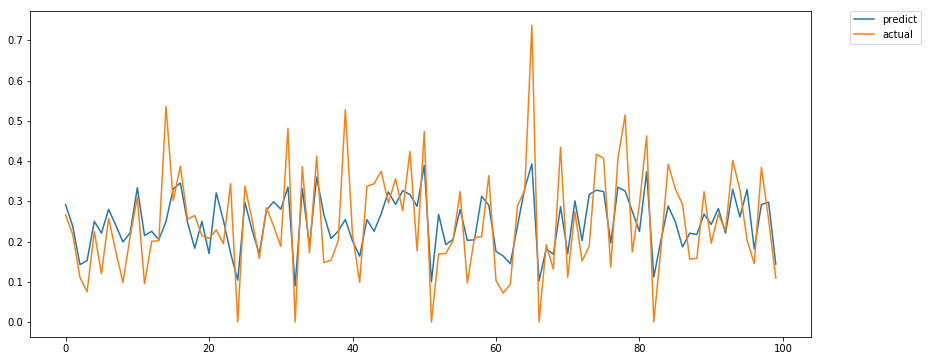

In [57]:
# showing results
scores = model.evaluate(x_test, y_test)
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}%".format(model.metrics_names[1], round(scores[1] * 100, 3)))

y_pred = model.predict(x_test)

score = mean_squared_error(y_test, y_pred)
print("mean_squared_error: {0}".format(round(score, 5)))

plt.figure(figsize=(14,6))
plt.plot(y_pred[:100], label="predict")
plt.plot(y_test[:100], label="actual")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()